In [1]:
# imports
import lxml.html as lh
import pandas as pd
from bs4 import BeautifulSoup
import json
import requests
import matplotlib.pyplot as plt
from functools import reduce


%matplotlib inline

In [2]:
race_json = []
with open('ultrasignup/races.txt', 'r') as f:
    for line in f:
        line = line[:-2]
        race_json.append(line[line.rfind('=')+1:])

In [3]:
race_json = list(dict.fromkeys(race_json)) # remove duplicates

In [4]:
# base url
url = 'http://ultrasignup.com/service/events.svc/results/{}/json?_search=false'

count = 0
df_list = []

# grab the data
for i in race_json:
    try:
        page = requests.get(url.format(i))
        results = page.json()
    except json.JSONDecodeError:
        continue
    # create df from JSON
    globals()['df' + str(count)] = pd.DataFrame.from_records(results)
    if len(globals()['df' + str(count)]) > 3: # arbitrary number but ensures no empty df comes in
        df_list.append(globals()['df' + str(count)])
    count += 1
# combine dfs into a final df 
df = reduce(lambda left,right: pd.merge(left,right,how='outer'), df_list)
len(df_list) # number of races scraped that had JSON, need to find a better way to scrape

1431

In [5]:
irrelevant = ['age_rank','photo_count','prior_count','race_count', 'drilldown',
              'time', 'status','bib', 'agegroup', 'participant_id'] # do not need these 
for col in df.columns:
    if col in irrelevant:
        del df[col]

df = df[df.age != 0] # does not contribute
df = df[df.state != ''] # does not contribute
df.head()

,age,city,firstname,formattime,gender,gender_place,lastname,place,runner_rank,state
246,33,,Jason,8:52:33,M,5,Bauer,5,77.09,MO
247,32,,James,8:54:27,M,6,Howton,6,74.94,AR
249,40,,Edward,9:04:14,M,7,Daly,8,79.22,MS
259,33,,Adrian,10:02:13,M,17,Belitu,18,68.78,IL
265,33,,David,10:18:23,M,23,Rich,24,71.78,OK


In [6]:
len(df) # number of participants

51894

In [7]:
# lists to create various dataframe
states = []
ages = []
num_part = []


# create empty dataframes
age_df = pd.DataFrame(columns=['state', 'avg_age'])
part_df = pd.DataFrame(columns=['state', 'participants'])

# iterate through each state
for state in df.state.unique():
    # find the average age and number of participants
    if df['state'].value_counts()[state] > 25:
        sum_age = df.loc[df['state'] == state, 'age'].sum()
        num_part.append(df['state'].value_counts()[state])
        avg_age = "{0:.2f}".format(sum_age / df['state'].value_counts()[state])
        states.append(state)
        ages.append(float(avg_age))
        
    else:
        df = df[df['state'] != state] # remove the small num of states
        
df.age.astype(int)
# populate the dataframes
age_df['state'] = states
age_df['avg_age'] = ages
part_df['state'] = states
part_df['participants'] = num_part
age_df.head()

,state,avg_age
0,MO,42.31
1,AR,42.26
2,MS,39.94
3,IL,42.13
4,OK,45.29


In [8]:
 # states with only one participant dont add much
part_df.head(100)

,state,participants
0,MO,385
1,AR,54
2,MS,173
3,IL,567
4,OK,100
5,NY,726
6,CO,1544
7,NJ,305
8,MD,1129
9,CA,24433


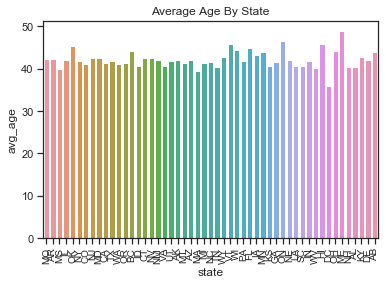

In [9]:
import seaborn as sns # visualize avg age
sns.set(style="ticks", color_codes=True)

plt.xticks(rotation=90,fontsize=10) # due this to avoid crowding
plt.title('Average Age By State')
sns.barplot(x='state', y='avg_age',data=age_df) # TODO visualize this better



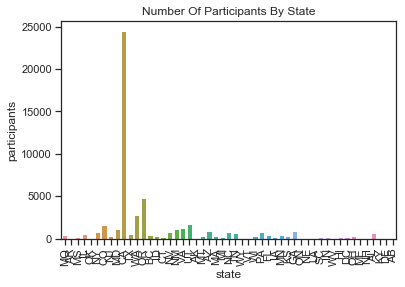

In [10]:
plt.xticks(rotation=90)
plt.title('Number Of Participants By State')
sns.barplot(x='state', y='participants',data=part_df)

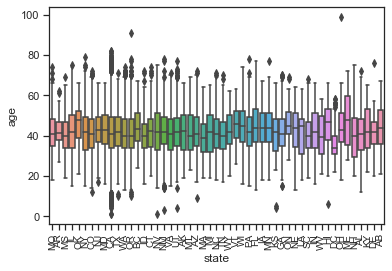

In [11]:
plt.xticks(rotation=90,fontsize=10)
sns.boxplot(x='state', y='age', data=df) # TODO clean this up a bit